<a href="https://colab.research.google.com/github/sahithiBudme/creditCardChurn/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

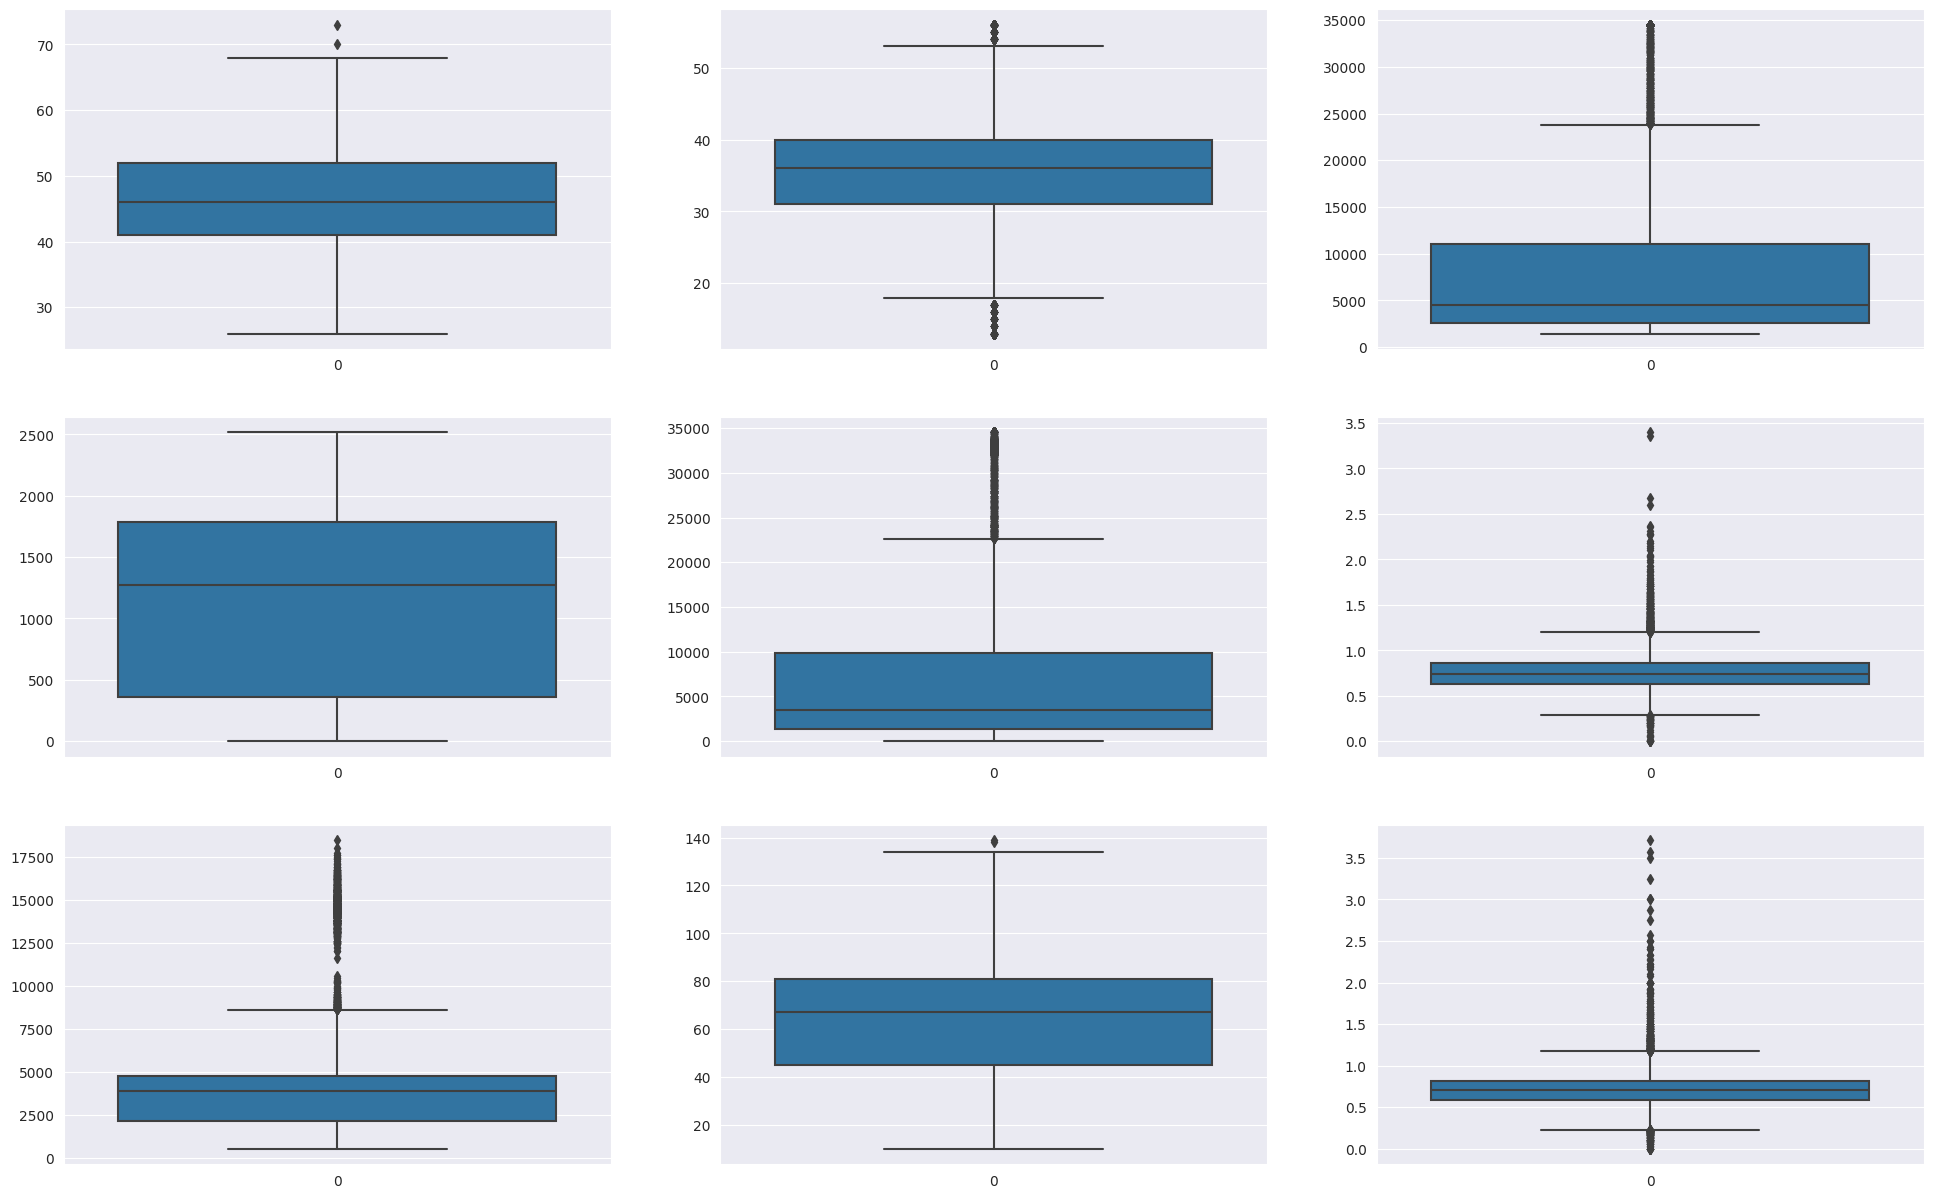

<ipython-input-1-55bcfa53a899>:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = pd.concat([eda_df, y], axis=1).corr()


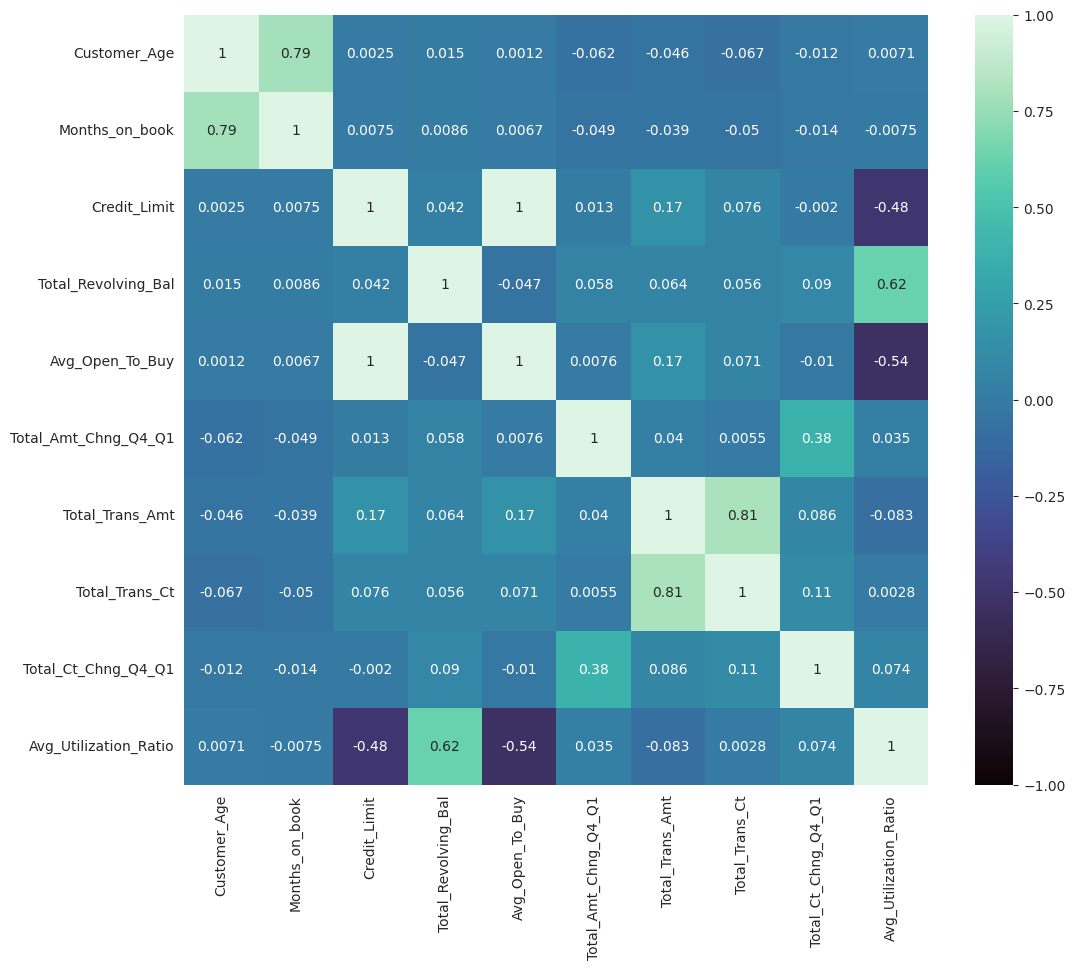

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
data = pd.read_csv('BankChurners.csv')
df=data.copy()
df=df.drop(df.columns[-2:],axis=1)
df.shape
df=df.drop('CLIENTNUM',axis=1)
df=df.replace('Unknown',np.NaN)
df.isna().sum()
eda_df = pd.concat([df.loc[:, ['Customer_Age', 'Months_on_book']],df.loc[:,'Credit_Limit':'Avg_Utilization_Ratio']], axis=1).copy()
eda_df
plt.figure(figsize=(24, 15))
for i in range(len(eda_df.columns) - 1):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(eda_df[eda_df.columns[i]])

plt.show()
y = df['Attrition_Flag'].copy()
corr = pd.concat([eda_df, y], axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df
def preprocess_inputs(df):
    df = df.copy()

    # Drop last two columns (unneeded)
    df = df.drop(df.columns[-2:], axis=1)

    # Drop CLIENTNUM columns
    df = df.drop('CLIENTNUM', axis=1)

    # Encode unknown values as np.NaN
    df = df.replace('Unknown', np.NaN)

    # Fill ordinal missing values with modes (Education_Level and Income_Category columns)
    df['Education_Level'] = df['Education_Level'].fillna('Graduate')
    df['Income_Category'] = df['Income_Category'].fillna('Less than $40K')

    # Encode binary columns
    df = binary_encode(df, 'Attrition_Flag', positive_value='Attrited Customer')
    df = binary_encode(df, 'Gender', positive_value='M')

    # Encode ordinal columns
    education_ordering = [
        'Uneducated',
        'High School',
        'College',
        'Graduate',
        'Post-Graduate',
        'Doctorate'
    ]
    income_ordering = [
        'Less than $40K',
        '$40K - $60K',
        '$60K - $80K',
        '$80K - $120K',
        '$120K +'
    ]
    df = ordinal_encode(df, 'Education_Level', ordering=education_ordering)
    df = ordinal_encode(df, 'Income_Category', ordering=income_ordering)

    # Encode nominal columns
    df = onehot_encode(df, 'Marital_Status', prefix='MS')
    df = onehot_encode(df, 'Card_Category', prefix='CC')

    # Split df into X and y
    y = df['Attrition_Flag'].copy()
    X = df.drop('Attrition_Flag', axis=1).copy()

    # Scale X with a standard scaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y
X, y = preprocess_inputs(data)
X.shape
X=X.drop('Customer_Age',axis=1).copy()
X.shape
X.head(1)
X=X.drop('Avg_Open_To_Buy',axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_up, y_up = oversample.fit_resample(X_train, y_train)
X_up1=X_up.to_numpy()
y_up1=y_up.to_numpy()
X_train1=X_train.to_numpy()
X_test1=X_test.to_numpy()
y_train1=y_train.to_numpy()

In [ ]:
from sklearn.model_selection import GridSearchCV,KFold
from xgboost import XGBClassifier
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1458 fits failed out of a total of 4374.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    

Best score: 0.9921391586120869
Best score: {'base_score': 0.5, 'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 5}


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
model = XGBClassifier (base_score=0.5, gamma= 0, learning_rate=0.05, n_estimators= 500, reg_alpha= 0, reg_lambda= 5,random_state=123)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2572
           1       0.92      0.88      0.90       467

    accuracy                           0.97      3039
   macro avg       0.95      0.93      0.94      3039
weighted avg       0.97      0.97      0.97      3039

Roc_auc score
-------------------------------------------------------
0.9312918566276255

Confusion matrix
-------------------------------------------------------
[[2538   34]
 [  58  409]]
